In [490]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, MDS
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import cosine_distances
import warnings
warnings.filterwarnings('ignore')

In [203]:
mut = pd.read_csv('TCGA.HNSC.mutations.txt', sep='\t', header=0, index_col = [0])

In [222]:
clean_mut = mut[mut['Variant_Type'] == 'SNP']
#Sigtool = clean_mut[['Hugo_Symbol', 'Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']]
#Sigtool.to_csv('Sigtool.cvs')
clean_mut = clean_mut[['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2', 'CONTEXT']]


In [205]:

def get_middle(sequence):
    middle_index = len(sequence) // 2
    if len(sequence) % 2 == 0:
        return sequence[middle_index - 1: middle_index + 1]
    else:
        return sequence[middle_index]
# Apply the function to the 'context' column
clean_mut['middle'] = clean_mut['CONTEXT'].apply(get_middle)


In [206]:
def reverse_complement(sequence):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return ''.join(complement[base] for base in sequence[::-1])
# Apply the reverse complement function based on the condition
clean_mut['Complement'] = clean_mut['CONTEXT']
clean_mut.loc[clean_mut['middle'].isin(['G', 'A']), 'Complement'] = clean_mut.loc[clean_mut['middle'].isin(['G', 'A']), 'Complement'].apply(reverse_complement)

In [207]:
def find_middle_three(s):
    length = len(s)
    if length >= 3:
        return s[(length//2)-1:(length//2)+2]
    else:
        return s
clean_mut['Tri'] = clean_mut['Complement'].apply(find_middle_three)

In [208]:
clean_mut['Mut'] = (clean_mut['Tri'].str[0] +  "(" + clean_mut['Tri'].str[1] + ">" 
                     + clean_mut['Tumor_Seq_Allele2'].astype(str) + ')' + clean_mut['Tri'].str[2])


In [209]:
clean_mut =  clean_mut[~clean_mut['Mut'].str.contains('(C>C)')]
clean_mut = clean_mut[~clean_mut['Mut'].str.contains('(T>T)')]

/var/folders/x1/0pbqqytx7775hcm5ys9z97y00000gn/T/ipykernel_1132/3941398218.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  clean_mut =  clean_mut[~clean_mut['Mut'].str.contains('(C>C)')]
/var/folders/x1/0pbqqytx7775hcm5ys9z97y00000gn/T/ipykernel_1132/3941398218.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  clean_mut = clean_mut[~clean_mut['Mut'].str.contains('(T>T)')]


In [218]:
clean_mut

,Chromosome,Start_Position,Reference_Allele,Tumor_Seq_Allele2,CONTEXT,middle,Complement,Tri,Mut
patient_id,,,,,,,,,
TCGA-4P-AA8J,10,22830863,G,A,CTCTCGCCCTC,G,GAGGGCGAGAG,GCG,G(C>A)G
TCGA-4P-AA8J,10,33495214,C,T,CATCTCTTCTT,C,CATCTCTTCTT,TCT,T(C>T)T
TCGA-4P-AA8J,10,6257188,C,T,GTGTTCAACGT,C,GTGTTCAACGT,TCA,T(C>T)A
TCGA-4P-AA8J,10,88260246,T,C,TAAAATACAGT,T,TAAAATACAGT,ATA,A(T>C)A
TCGA-4P-AA8J,11,1080567,T,C,TTCGATGGGAA,T,TTCGATGGGAA,ATG,A(T>C)G
...,...,...,...,...,...,...,...,...,...
TCGA-WA-A7H4,8,143381872,C,T,CCTCCCGCAGC,C,CCTCCCGCAGC,CCG,C(C>T)G
TCGA-WA-A7H4,8,59728263,G,A,TTCACGTCAAC,G,GTTGACGTGAA,ACG,A(C>A)G
TCGA-WA-A7H4,8,74235183,G,A,GTATCGGTTCC,G,GGAACCGATAC,CCG,C(C>A)G


In [211]:
mut_matrix = clean_mut[['Mut']]

In [212]:
mut_encoded_matrix = pd.pivot_table(mut_matrix, index='patient_id', columns='Mut', aggfunc='size', fill_value=0)

In [213]:
mut_encoded_matrix

Mut,A(C>A)A,A(C>A)C,A(C>A)G,A(C>A)T,A(C>G)A,A(C>G)C,A(C>G)G,A(C>G)T,A(C>T)A,A(C>T)C,...,T(T>A)G,T(T>A)T,T(T>C)A,T(T>C)C,T(T>C)G,T(T>C)T,T(T>G)A,T(T>G)C,T(T>G)G,T(T>G)T
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-4P-AA8J,1,0,7,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
TCGA-BA-4074,5,1,5,1,0,1,0,1,2,1,...,0,0,0,0,1,0,0,0,0,0
TCGA-BA-4075,3,5,3,3,0,0,0,1,1,5,...,0,1,0,0,0,1,2,0,0,2
TCGA-BA-4076,9,5,7,5,0,1,1,2,7,8,...,1,1,1,1,3,0,2,2,4,1
TCGA-BA-4077,1,1,4,0,0,0,0,0,1,1,...,0,1,0,1,0,1,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-UF-A7JT,4,2,2,1,1,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-UF-A7JV,0,0,1,1,0,0,0,0,2,1,...,1,1,0,1,0,0,0,0,0,0
TCGA-UP-A6WW,0,0,3,1,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1


In [514]:
import numpy as np
from sklearn.decomposition import NMF
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
# Step 1: Convert somatic mutations into a mutational matrix M
stability_scores = []
reconstruction_errors = []
M = mut_encoded_matrix
# Your code to generate or load the mutational matrix M
# Step 2: Perform NMF with different ranks and select the optimal rank based on stability and reconstruction
# Define the range of ranks to test
rank_range = range(2, 20)  # Modify the range as needed
# Initialize variables for storing stability scores and reconstruction errors
# Perform NMF for each rank
for k in rank_range:
    # Initialize variables to store scores for this rank
    rank_stability_scores = []
    rank_reconstruction_errors = []
    # Perform multiple factorizations
    for _ in range(100):
        # Step 3: Poisson resampling and normalization
        M_resampled = np.random.poisson(M)
        M_normalized = M_resampled
        # Step 4: Perform NMF with rank k
        nmf = NMF(n_components=k)
        W = nmf.fit_transform(M_normalized) #E thing to be used for graph contribution og mutational 
        H = nmf.components_
        # Step 5: Evaluate stability using silhouette score
        labels = KMeans(n_clusters=k).fit_predict(W)
        stability_score = silhouette_score(W, labels)
        # Calculate reconstruction error (optional)
        reconstruction_error = np.linalg.norm(M_normalized - np.dot(W, H))
        # Store stability score and reconstruction error for this factorization
        rank_stability_scores.append(stability_score)
        rank_reconstruction_errors.append(reconstruction_error)
    # Calculate average stability score and reconstruction error for this rank
    average_stability_score = np.mean(rank_stability_scores)
    average_reconstruction_error = np.mean(rank_reconstruction_errors)
    # Store the average scores for this rank
    stability_scores.append(average_stability_score)
    reconstruction_errors.append(average_reconstruction_error)

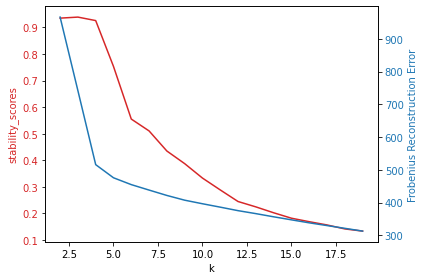

In [515]:
# Plot signature reproducibility and Frobenius reconstruction error
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('stability_scores', color=color)
ax1.plot(range(2,20), stability_scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Frobenius Reconstruction Error', color=color)
ax2.plot(range(2,20), reconstruction_errors, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [547]:

#from sklearn.decomposition import PCA
M = mut_encoded_matrix
#pca = PCA(n_components=2)
#df_pca = pca.fit_transform(df_scaled)
nmf = NMF(n_components=5)
W = nmf.fit_transform(M)  
H = nmf.components_  


In [543]:
W

(96, 5)

In [546]:
H

array([[0.19054907, 0.1864045 , 0.337433  , ..., 0.00215786, 0.        ,
        0.02512753],
       [0.48163573, 0.16217685, 0.21979035, ..., 0.06595651, 1.02196628,
        0.18614348],
       [0.        , 0.21253892, 0.1764429 , ..., 0.0607004 , 0.16547974,
        0.03611475],
       [0.17663464, 0.09042839, 0.03070484, ..., 0.10519297, 0.20201954,
        0.11320636],
       [0.21873443, 0.56097062, 0.63701983, ..., 0.1656565 , 0.58610923,
        0.19394803]])

In [548]:
signitures = pd.DataFrame(H)
signitures.columns =  mut_encoded_matrix.columns
signitures

Mut,A(C>A)A,A(C>A)C,A(C>A)G,A(C>A)T,A(C>G)A,A(C>G)C,A(C>G)G,A(C>G)T,A(C>T)A,A(C>T)C,...,T(T>A)G,T(T>A)T,T(T>C)A,T(T>C)C,T(T>C)G,T(T>C)T,T(T>G)A,T(T>G)C,T(T>G)G,T(T>G)T
0,0.158951,2.603270,0.139844,0.575281,0.034479,0.059812,0.034888,0.000000,0.291075,2.190358,...,0.049258,0.292969,0.181692,0.059768,0.206176,0.143376,0.213553,0.063657,0.240822,0.183167
1,0.196941,0.102303,0.822965,0.115222,0.109546,0.117814,0.029918,0.192129,0.145499,0.104210,...,0.000000,0.057698,0.000000,0.045579,0.003571,0.032181,0.000000,0.072220,0.019996,0.014094
2,0.466959,0.000000,0.089977,0.497135,0.000603,0.003399,0.002238,0.000000,0.946526,0.120201,...,0.002099,0.027164,0.000000,0.051935,0.019670,0.023100,0.000000,0.000000,0.098003,0.037351
3,0.767515,0.749954,4.663944,0.702709,0.053041,0.104928,0.000000,0.028655,0.815037,0.676571,...,0.000000,0.095935,1.942665,2.071537,1.446273,1.577390,1.320363,1.258775,1.179528,1.668400
4,3.321430,2.692051,4.306795,1.782016,0.863711,0.635627,0.448756,0.664859,3.320758,2.841335,...,0.469978,0.312552,0.548217,0.462888,0.595182,0.573364,0.434272,0.414332,0.817586,0.585801


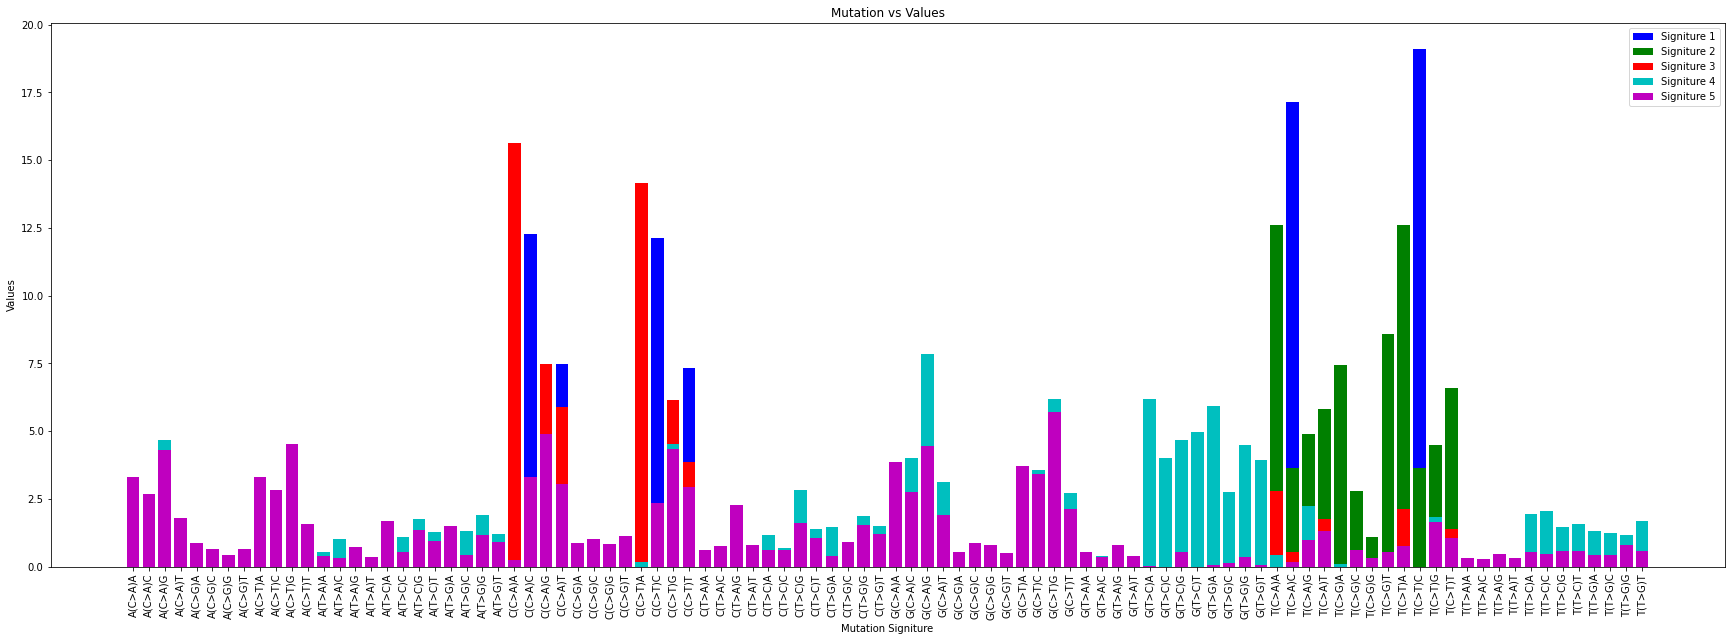

In [554]:
colors = ['b', 'g', 'r', 'c', 'm']
plt.figure(figsize=(30, 10))
for i in range(signitures.shape[0]):
    plt.bar(signitures.columns, signitures.iloc[i, :], color=colors[i % len(colors)], label=f'Signiture {i+1}')
plt.xlabel('Mutation Signiture')
plt.ylabel('Values')
plt.title('Mutation vs Values')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [529]:
signi_one

array([1.58950979e-01, 2.60327047e+00, 1.39843784e-01, 5.75281429e-01,
       3.44792290e-02, 5.98121584e-02, 3.48884390e-02, 0.00000000e+00,
       2.91075178e-01, 2.19035809e+00, 2.22125135e-02, 7.08940758e-01,
       1.24141730e-01, 5.49039982e-02, 0.00000000e+00, 2.58790318e-01,
       7.98877745e-02, 4.82726216e-02, 9.74996064e-02, 5.11805755e-02,
       2.87985664e-02, 4.68306630e-02, 3.14964226e-01, 7.03224066e-02,
       4.53924129e+00, 1.22686660e+01, 2.93219435e+00, 7.49558794e+00,
       0.00000000e+00, 0.00000000e+00, 5.19497025e-02, 9.59707442e-02,
       4.71988169e+00, 1.21109081e+01, 2.73044471e+00, 7.32840893e+00,
       3.86167690e-02, 4.19131074e-02, 1.37352677e-02, 2.07758116e-01,
       6.72949952e-02, 1.12343591e-01, 3.62846841e-01, 2.97736284e-01,
       1.15698845e-01, 1.48038662e-01, 1.35178952e-01, 1.34885046e-01,
       5.39961241e-02, 2.32860716e+00, 0.00000000e+00, 7.59238365e-01,
       0.00000000e+00, 0.00000000e+00, 2.81408897e-02, 0.00000000e+00,
      

In [528]:
W.shape

(500, 5)

In [87]:
column_sums = np.sum(coefficient, axis=0)

# Index of the original feature most influenced by the hidden features
most_influenced_feature = np.argmax(column_sums)
most_influenced_feature

72

In [88]:
mut_matrix.iloc[72]

Mut    G(T>C)C
Name: (TCGA-4P-AA8J, KDM1A), dtype: object

In [ ]:
df_resampled

In [97]:
from SigProfilerExtractor import sigpro as sig
path_to_example_table = sig.importdata("matrix")
data = path_to_example_table 

ModuleNotFoundError: No module named 'SigProfilerExtractor'